# Creating a source model from PVGIS

In this notebook we go through the steps of creating an LSTM model that has been trained on synthetic data which we fetch from PVGIS through their API.

![PVGIS](../../PVGIS.png)

Figure 1: PVGIS

## 1. Fetching data from PVGIS

In [13]:
# Import the datafetcher class
from src.data.datafetcher import PvFetcher

# Set parameters
latitude = 51
longitude = 5
peakPower = 2.4
tilt = 33
azimuth = 0

# Fetch data from PVGIS
data = PvFetcher(latitude,longitude,peakPower,tilt,azimuth, locations=1)

# Save the data in the data folder
path = data.save_data()
path

Gathering data from base location...


'dataset_240326_1316.pkl'

In [14]:
# Show some of the data
data.dataset[0].head()

,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
time,,,,,,,,
2005-01-01 00:00:00,0.000,0.000,0.000,0.000,0.000,7.560,2.210,0
2005-01-01 01:00:00,0.000,0.000,0.000,0.000,0.000,7.060,2.140,0
2005-01-01 02:00:00,0.000,0.000,0.000,0.000,0.000,6.660,2.070,0
2005-01-01 03:00:00,0.000,0.000,0.000,0.000,0.000,6.090,1.520,0
2005-01-01 04:00:00,0.000,0.000,0.000,0.000,0.000,5.830,1.240,0


## 2. Preparing the data for use in the model

### 2.1 Selecting and adding features

In [15]:
# Import the featurisation class
from src.data.featurisation import Featurisation

# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
dataset = Featurisation(data.dataset).base_features(['P', 'Gb(i)', 'T2m'])

# Use daily cyclic features as well
dataset = Featurisation(dataset).cyclic_features()

![Cyclical_time_features](../../cosine-sine_coordinates.png)

Figure 2: Using cyclical features

In [16]:
# Show the featurized dataset
dataset[0].head()

,P,Gb(i),T2m,hour_sin,hour_cos,month_sin,month_cos
time,,,,,,,
2005-01-01 00:00:00,0.000,0.000,7.560,0.000,1.000,0.500,0.866
2005-01-01 01:00:00,0.000,0.000,7.060,0.259,0.966,0.500,0.866
2005-01-01 02:00:00,0.000,0.000,6.660,0.500,0.866,0.500,0.866
2005-01-01 03:00:00,0.000,0.000,6.090,0.707,0.707,0.500,0.866
2005-01-01 04:00:00,0.000,0.000,5.830,0.866,0.500,0.500,0.866


### 2.2 Transforming the dataframe to tensors

In [17]:
# Import the tensorisation class to transform the data into tensors for use in pytorch models
from src.tensors.tensorisation import Tensorisation
import torch

# Get the list of features
features = list(dataset[0].columns)
lags = 24
forecast_period = 24

# Get the tensors
X_train_tot = torch.empty(0, dtype=torch.float32)
X_test_tot = torch.empty(0, dtype=torch.float32)
y_train_tot = torch.empty(0, dtype=torch.float32)
y_test_tot = torch.empty(0, dtype=torch.float32)

for i in range(len(dataset)):
    tensors = Tensorisation(dataset[i], 'P', features, lags, forecast_period)
    X_train, X_test, y_train, y_test = tensors.tensor_creation()
    X_train_tot = torch.concat([X_train_tot, X_train])
    X_test_tot = torch.concat([X_test_tot, X_test])
    y_train_tot = torch.concat([y_train_tot, y_train])
    y_test_tot = torch.concat([y_test_tot, y_test])
    
X_train_tot.shape, X_test_tot.shape, y_train_tot.shape, y_test_tot.shape

(torch.Size([4674, 24, 7]),
 torch.Size([1169, 24, 7]),
 torch.Size([4674, 24, 1]),
 torch.Size([1169, 24, 1]))

## 3. Creating and training the model

In [18]:
# Import the lstm class to create an untrained LSTM
from src.models.lstm import LSTM

# Set the parameters for the lstm
input_size = len(features)
hidden_size = 50
num_layers = 2
dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(7, 50, num_layers=2, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=50, out_features=24, bias=True)
)

Step 0: Average train loss: 0.0245 | Average test loss: 0.0160
Step 5: Average train loss: 0.0165 | Average test loss: 0.0154
Step 10: Average train loss: 0.0162 | Average test loss: 0.0150
Step 15: Average train loss: 0.0161 | Average test loss: 0.0148
Best Epoch: 19


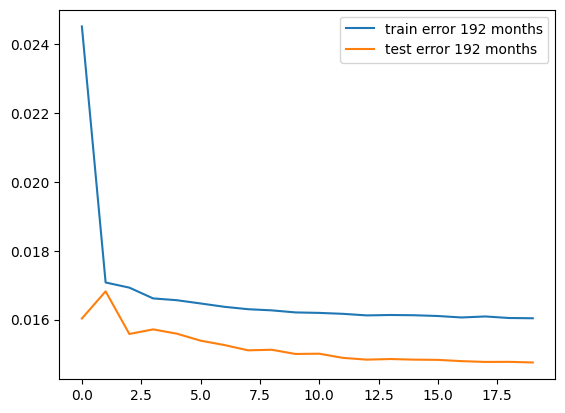

In [20]:
# Import the training class to train the model
from src.models.training import Training

# Set the training parameters
epochs = 20

# Initialize the trainer
training = Training(my_lstm, X_train_tot, y_train_tot, X_test_tot, y_test_tot, epochs)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit()

In [21]:
# Load the state dictionary of the best performing model

my_lstm.load_state_dict(state_dict_list[best_epoch])

<All keys matched successfully>

In [22]:
# Save the model state dictionary for later use
from src.models.training import save_model

save_model(my_lstm, 'example_model')

## 4. Inference and evaluation

In [23]:
# Forecast with the model
forecasts = my_lstm(X_test_tot.to(device))

In [24]:
# Import the evaluation script
from src.evaluation.evaluation import Evaluation

# Evaluate the model performance
eval = Evaluation(y_test_tot.detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

# Show the evaluation metrics
eval.metrics()['RMSE']

Metrics   0.122
Name: RMSE, dtype: float32

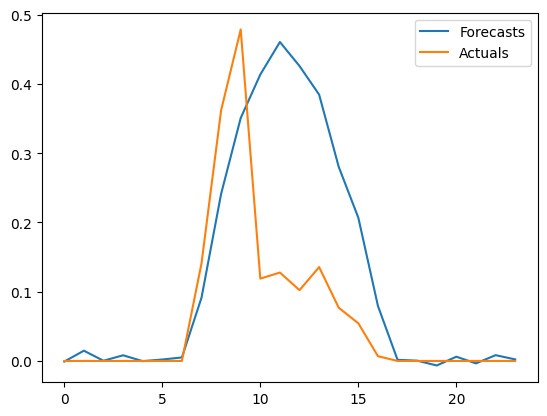

In [25]:
# Plot some of the forecasts
import matplotlib.pyplot as plt

plt.plot(forecasts[0].cpu().detach().numpy(), label="Forecasts")
plt.plot(y_test_tot[0], label="Actuals")

plt.legend()
plt.show()